# FEniCSx H and P Tutorial

For this tutorial, we are going to work off of our analytical solution and compare how P and H refinement affects the results. For H refinement, we will first change the mesh size to extremely fine, and then for P refinement, we will use our second order solver with a slightly finer mesh than our analytic answer.


Before getting into the problem, please ensure that FEniCSx and DolfinX are installed on your computer. For assistance with installation, please refer to the `readme.md` for tips on installing the platform, creating a conda environment, activating it (also in your terminal/visual studio session), and running the Jupyter Notebook.

## H Refinement

We are not going to go into as much detail as we did in our analytic solution tutorial and instead get right to the problem. For H refinement, we are going to reduce our Lagrange quadrature to 1, and set our mesh to be extremely fine (100x25x25). Once we run this, we can then compare our solution to the analytical problem.


In [ ]:
from dolfinx import mesh, fem, default_scalar_type
from dolfinx.fem.petsc import LinearProblem
from dolfinx import geometry
from mpi4py import MPI
import dolfinx.fem.petsc
import matplotlib.pyplot as plt
import numpy as np
import ufl

In [ ]:
# Bridge dimensions
L, W, H = 10.0, 1.0, 0.5  # Length, width, height
num_elements = [100, 25, 25]  # Mesh resolution 

# Create a 3D bridge mesh
domain = mesh.create_box(MPI.COMM_WORLD, [[0.0, 0.0, 0.0], [L, W, H]], num_elements, mesh.CellType.hexahedron)
V = fem.functionspace(domain, ("Lagrange", 1, (domain.geometry.dim, )))
dim = domain.topology.dim

# Material properties for bridge
rho = 800  # Density 
E = fem.Constant(domain, 2.1e11)  
nu = fem.Constant(domain, 0.3)
mu = (E / (2 * (1 + nu)))
lmbda = (E * nu / ((1 + nu) * (1 - 2 * nu)))


In [ ]:
# Define the weak form
u = ufl.TrialFunction(V)  # Displacement as a vector field
v = ufl.TestFunction(V)  # Test function
solution = fem.Function(V)  # Solution vector

def epsilon(v):
    return ufl.sym(ufl.grad(v))


def sigma(v):
    return lmbda * ufl.tr(epsilon(v)) * ufl.Identity(dim) + 2 * mu * epsilon(v)

In [ ]:
# Boundary conditions: Fix both ends of the bridge
def left_end(x):
    return np.isclose(x[0], 0.0)

def right_end(x):
    return np.isclose(x[0], L)


left_dofs = fem.locate_dofs_geometrical(V, left_end)
right_dofs = fem.locate_dofs_geometrical(V, right_end)
zero_displacement = np.array([0.0, 0.0, 0.0], dtype=default_scalar_type)
bcs = [fem.dirichletbc(zero_displacement, left_dofs, V),
       fem.dirichletbc(zero_displacement, right_dofs, V)]

In [ ]:
# External force: Vertical force applied uniformly
q = fem.Constant(domain, default_scalar_type((0.0, 0.0, -1e4)))  # Force in the negative z-direction
dx = ufl.Measure("dx", domain=domain)
a = ufl.inner(sigma(u), epsilon(v)) * dx
L_form = ufl.inner(q, v) * dx

In [ ]:
# Solver setup using a linear solver
problem = LinearProblem(a, L_form, bcs=bcs, u=solution)

def Monitor(ksp, iterations, residual_norm):
    print(f"Iteration {iterations}, residual {residual_norm}")

problem.solver.setMonitor(Monitor)
problem.solver.setTolerances(rtol=1e-9, atol=1e-9)

problem.solve()

In [ ]:
# Define the moment of inertia for the beam's cross-section
Inertia = W * H**3 / 12  # Assuming a rectangular cross-section

# Bounding box tree for collision detection
bb_tree = geometry.bb_tree(domain, domain.topology.dim)

# Define points along the beam's length for displacement evaluation
x = np.linspace(0, L, 100)
points = np.zeros((3, 100))
points[0] = x
points[1] = W / 2  # Mid-width of the beam
points[2] = H / 2  # Mid-height of the beam

cells = []
points_on_proc = []
u_values = []

# Find cells containing the points
cell_candidates = geometry.compute_collisions_points(bb_tree, points.T)
colliding_cells = geometry.compute_colliding_cells(domain, cell_candidates, points.T)
for i, point in enumerate(points.T):
    if len(colliding_cells.links(i)) > 0:
        points_on_proc.append(point)
        cells.append(colliding_cells.links(i)[0])

points_on_proc = np.array(points_on_proc, dtype=np.float64)
u_values = solution.eval(points_on_proc, cells)

# Plot FEA results
fig = plt.figure()
plt.plot(points_on_proc[:, 0], u_values[:, 2], "k", linewidth=2, label="FEA")  # Z-displacement
plt.grid(True)

# Define the analytic solution for comparison
u_analytic = lambda x: (q.value[2] / (24 * E.value * Inertia)) * (x**4 - 2 * L * x**3 + L**3 * x)
x_analytic = np.linspace(0, L, 100)
u_analytic_values = u_analytic(x_analytic)

# Compute and save the error
error = np.max(np.abs(u_values[:, 2] - u_analytic_values))
print(f"Error: {error}")

# Plot analytic solution
plt.plot(x_analytic, u_analytic_values, "r", linewidth=2, label="Analytic")
plt.grid(True)
plt.xlabel("x")
plt.ylabel("Displacement (Z)")
plt.legend()
output_png = "H_refinement_error.png"
plt.savefig(output_png)

## Results

We can see the changes in our solution when looking at the `H_refinement_error.png`. While this error isn't too far off from our analytical answer, it is still more accurate than before. It will be even more accurate the finer the mesh, especially if we have different material properties and a different load.

## P Refinement

This section goes over the setup for P refinement. Our main changes in this section are the quadrature is set to 2, and our mesh is set to 50, 10, 10.

In [ ]:
# Bridge dimensions
L, W, H = 10.0, 1.0, 0.5  # Length, width, height
num_elements = [50, 10, 10]  # Mesh resolution 

# Create a 3D bridge mesh
domain = mesh.create_box(MPI.COMM_WORLD, [[0.0, 0.0, 0.0], [L, W, H]], num_elements, mesh.CellType.hexahedron)
V = fem.functionspace(domain, ("Lagrange", 2, (domain.geometry.dim, )))
dim = domain.topology.dim

# Material properties for bridge
rho = 800  # Density 
E = fem.Constant(domain, 2.1e11)  
nu = fem.Constant(domain, 0.3)
mu = (E / (2 * (1 + nu)))
lmbda = (E * nu / ((1 + nu) * (1 - 2 * nu)))

# Define the weak form
u = ufl.TrialFunction(V)  # Displacement as a vector field
v = ufl.TestFunction(V)  # Test function
solution = fem.Function(V)  # Solution vector

def epsilon(v):
    return ufl.sym(ufl.grad(v))


def sigma(v):
    return lmbda * ufl.tr(epsilon(v)) * ufl.Identity(dim) + 2 * mu * epsilon(v)

# Boundary conditions: Fix both ends of the bridge
def left_end(x):
    return np.isclose(x[0], 0.0)

def right_end(x):
    return np.isclose(x[0], L)


left_dofs = fem.locate_dofs_geometrical(V, left_end)
right_dofs = fem.locate_dofs_geometrical(V, right_end)
zero_displacement = np.array([0.0, 0.0, 0.0], dtype=default_scalar_type)
bcs = [fem.dirichletbc(zero_displacement, left_dofs, V),
       fem.dirichletbc(zero_displacement, right_dofs, V)]

# External force: Vertical force applied uniformly
q = fem.Constant(domain, default_scalar_type((0.0, 0.0, -1e4)))  # Force in the negative z-direction
dx = ufl.Measure("dx", domain=domain)
a = ufl.inner(sigma(u), epsilon(v)) * dx
L_form = ufl.inner(q, v) * dx

# Solver setup using a linear solver
problem = LinearProblem(a, L_form, bcs=bcs, u=solution)

def Monitor(ksp, iterations, residual_norm):
    print(f"Iteration {iterations}, residual {residual_norm}")

problem.solver.setMonitor(Monitor)
problem.solver.setTolerances(rtol=1e-8, atol=1e-8)

problem.solve()

# Define the moment of inertia for the beam's cross-section
Inertia = W * H**3 / 12  # Assuming a rectangular cross-section

# Bounding box tree for collision detection
bb_tree = geometry.bb_tree(domain, domain.topology.dim)

# Define points along the beam's length for displacement evaluation
x = np.linspace(0, L, 100)
points = np.zeros((3, 100))
points[0] = x
points[1] = W / 2  # Mid-width of the beam
points[2] = H / 2  # Mid-height of the beam

cells = []
points_on_proc = []
u_values = []

# Find cells containing the points
cell_candidates = geometry.compute_collisions_points(bb_tree, points.T)
colliding_cells = geometry.compute_colliding_cells(domain, cell_candidates, points.T)
for i, point in enumerate(points.T):
    if len(colliding_cells.links(i)) > 0:
        points_on_proc.append(point)
        cells.append(colliding_cells.links(i)[0])

points_on_proc = np.array(points_on_proc, dtype=np.float64)
u_values = solution.eval(points_on_proc, cells)

# Plot FEA results
fig = plt.figure()
plt.plot(points_on_proc[:, 0], u_values[:, 2], "k", linewidth=2, label="FEA")  # Z-displacement
plt.grid(True)

# Define the analytic solution for comparison
u_analytic = lambda x: (q.value[2] / (24 * E.value * Inertia)) * (x**4 - 2 * L * x**3 + L**3 * x)
x_analytic = np.linspace(0, L, 100)
u_analytic_values = u_analytic(x_analytic)

# Compute and save the error
error = np.max(np.abs(u_values[:, 2] - u_analytic_values))
print(f"Error: {error}")

# Plot analytic solution
plt.plot(x_analytic, u_analytic_values, "r", linewidth=2, label="Analytic")
plt.grid(True)
plt.xlabel("x")
plt.ylabel("Displacement (Z)")
plt.legend()
output_png = "P_refinement_error.png"
plt.savefig(output_png)

## Results

Our results for P refinement are very similar to H refinement, except the biggest difference now is the runtime. Where H refinement gave us a clearer image because of a finer mesh, the higher quadrature gave us a very accurate answer in a much shorter time period. If we were to adjust this by changing the tolerance or load parameters, it would yield and even more accurate result.

Elements: [1, 1, 1], Error: 0.0005951652176166476
Elements: [5, 1, 1], Error: 0.0005875324180502908
Elements: [10, 1, 1], Error: 0.0005732581127532932
Elements: [10, 2, 2], Error: 0.0005722889644421936
Elements: [10, 5, 5], Error: 0.0005719108954839769
Elements: [15, 5, 5], Error: 0.0005604008288722271
Elements: [20, 5, 5], Error: 0.0005526082381043151
Elements: [25, 5, 5], Error: 0.0005479007750850208
Elements: [30, 5, 5], Error: 0.0005447239487859595
Elements: [30, 10, 5], Error: 0.0005445909522971207
Elements: [30, 10, 10], Error: 0.0005444055243090838
Elements: [50, 10, 10], Error: 0.0005389274201688512


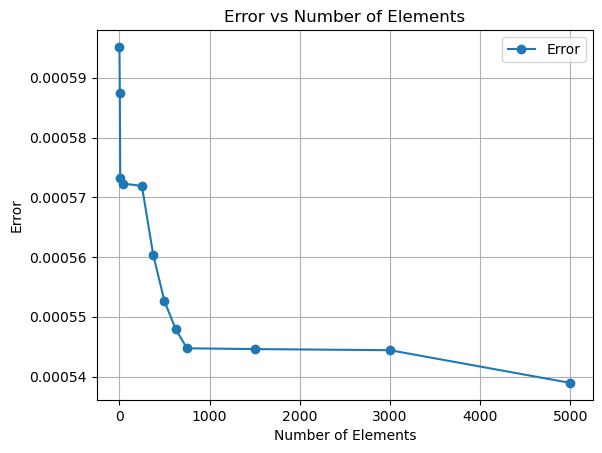

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from dolfinx import mesh, fem, geometry, default_scalar_type
from dolfinx.fem.petsc import LinearProblem
from mpi4py import MPI
import ufl

L, W, H = 10.0, 1.0, 0.5  # Length, width, height

# Function to compute error for a given number of elements
def compute_error(num_elements):
    # Create a 3D bridge mesh
    domain = mesh.create_box(MPI.COMM_WORLD, [[0.0, 0.0, 0.0], [L, W, H]], num_elements, mesh.CellType.hexahedron)
    V = fem.functionspace(domain, ("Lagrange", 1, (domain.geometry.dim, )))
    dim = domain.topology.dim

    # Material properties for bridge
    rho = 800  # Density 
    E = fem.Constant(domain, 2.1e11)  
    nu = fem.Constant(domain, 0.3)
    mu = (E / (2 * (1 + nu)))
    lmbda = (E * nu / ((1 + nu) * (1 - 2 * nu)))

    # Define the weak form
    u = ufl.TrialFunction(V)  # Displacement as a vector field
    v = ufl.TestFunction(V)  # Test function
    solution = fem.Function(V)  # Solution vector

    def epsilon(v):
        return ufl.sym(ufl.grad(v))


    def sigma(v):
        return lmbda * ufl.tr(epsilon(v)) * ufl.Identity(dim) + 2 * mu * epsilon(v)

    # Boundary conditions: Fix both ends of the bridge
    def left_end(x):
        return np.isclose(x[0], 0.0)

    def right_end(x):
        return np.isclose(x[0], L)


    left_dofs = fem.locate_dofs_geometrical(V, left_end)
    right_dofs = fem.locate_dofs_geometrical(V, right_end)
    zero_displacement = fem.Constant(domain, np.array([0.0, 0.0, 0.0], dtype=default_scalar_type))
    bcs = [fem.dirichletbc(zero_displacement, left_dofs, V),
        fem.dirichletbc(zero_displacement, right_dofs, V)]

    # External force: Vertical force applied uniformly
    q = fem.Constant(domain, default_scalar_type((0.0, 0.0, -1e4)))  # Force in the negative z-direction
    dx = ufl.Measure("dx", domain=domain)
    a = ufl.inner(sigma(u), epsilon(v)) * dx
    L_form = ufl.inner(q, v) * dx

    # Solve the problem
    problem = LinearProblem(a, L_form, bcs=bcs, u=solution)
    problem.solve()

    # Compute the error
    Inertia = W * H**3 / 12  # Moment of inertia for cross-section
    u_analytic = lambda x: (q.value[2] / (24 * E.value * Inertia)) * (x**4 - 2 * L * x**3 + L**3 * x)
    x = np.linspace(0, L, 100)
    points = np.zeros((3, 100))
    points[0] = x
    points[1] = W / 2
    points[2] = H / 2

    bb_tree = geometry.bb_tree(domain, domain.topology.dim)
    cell_candidates = geometry.compute_collisions_points(bb_tree, points.T)
    colliding_cells = geometry.compute_colliding_cells(domain, cell_candidates, points.T)

    points_on_proc = []
    cells = []
    for i, point in enumerate(points.T):
        if len(colliding_cells.links(i)) > 0:
            points_on_proc.append(point)
            cells.append(colliding_cells.links(i)[0])

    points_on_proc = np.array(points_on_proc, dtype=np.float64)
    u_values = solution.eval(points_on_proc, cells)

    u_analytic_values = u_analytic(points_on_proc[:, 0])
    error = np.max(np.abs(u_values[:, 2] - u_analytic_values))
    return error

# Loop over different mesh resolutions and compute errors
num_elements_list = [[1, 1, 1], [5, 1, 1], [10, 1, 1], [10, 2, 2], [10, 5, 5], [15, 5, 5], [20, 5, 5], [25, 5, 5], [30, 5, 5], [30, 10, 5], [30, 10, 10], [50, 10, 10]]
errors = []

for num_elements in num_elements_list:
    error = compute_error(num_elements)
    errors.append(error)
    print(f"Elements: {num_elements}, Error: {error}")

# Plot the error vs number of elements
num_elements_flat = [np.prod(ne) for ne in num_elements_list]  # Total number of elements
plt.figure()
plt.plot(num_elements_flat, errors, marker="o", label="Error")
plt.xlabel("Number of Elements")
plt.ylabel("Error")
plt.title("Error vs Number of Elements")
plt.grid(True)
plt.legend()
plt.savefig("Error_vs_Number_of_Elements.png")
plt.show()

## Num. of Elements vs Error

As we can see from the plot above and the saved `Error_vs_Number_of_Elements.png`, the more elements we have, the finer the mesh, the more accurate the results. This is consistent with our previous findings and our computed results are validated through this.